In [23]:
# Preprocesamiento y análisis de datos
import pandas as pd
import numpy as np

# NLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score # K-Folds cross validation
from sklearn.model_selection import GridSearchCV

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Loading Data

In [25]:
train_data = pd.read_csv("../data/train_data.csv")
test_data = pd.read_csv("../data/test_data.csv") 
train_data.columns

Index(['Veracity', 'News'], dtype='object')

# Preprocessing training data

In [27]:
# Modificar solo la segunda columna del DataFrame
train_data.iloc[:, 1] = train_data.iloc[:, 1].replace("[^a-zA-Z]", " ", regex=True)
test_data.iloc[:, 1] = test_data.iloc[:, 1].replace("[^a-zA-Z]", " ", regex=True)

# Count Vectorizer

In [29]:
"""vectorizer = CountVectorizer(
    ngram_range=(1, 2),  # Incluye unigrams y bigrams
    max_features=5000,   # Limita a 5000 características más frecuentes
    stop_words='english' # Elimina palabras comunes en inglés
)

# Ajustar el vectorizador a los datos de entrenamiento y transformar
X_train = vectorizer.fit_transform(train_data['News'])

# Transformar los datos de prueba
X_test = vectorizer.transform(test_data['News'])

# Ver las características generadas
print("Características generadas:", vectorizer.get_feature_names_out())
print("Shape de X_train:", X_train.shape)"""

'vectorizer = CountVectorizer(\n    ngram_range=(1, 2),  # Incluye unigrams y bigrams\n    max_features=5000,   # Limita a 5000 características más frecuentes\n    stop_words=\'english\' # Elimina palabras comunes en inglés\n)\n\n# Ajustar el vectorizador a los datos de entrenamiento y transformar\nX_train = vectorizer.fit_transform(train_data[\'News\'])\n\n# Transformar los datos de prueba\nX_test = vectorizer.transform(test_data[\'News\'])\n\n# Ver las características generadas\nprint("Características generadas:", vectorizer.get_feature_names_out())\nprint("Shape de X_train:", X_train.shape)'

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 3))
X_train = vectorizer.fit_transform(train_data['News'])
X_test = vectorizer.transform(test_data['News'])

# Model Creation

In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def get_models():
    """
    Retorna un diccionario con los mejores modelos de clasificación supervisada.
    """
    models = {
        'Naive Bayes': MultinomialNB(),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    }
    return models

# Model Training and Cross Validation

In [54]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_models(models, X_train, y_train, X_test, y_test, threshold=0.5):
    """
    Entrena y evalúa múltiples modelos de clasificación supervisada con un umbral ajustable.
    """
    results = {}
    
    for name, model in models.items():
        print(f"Entrenando y evaluando el modelo: {name}")
        # Entrenar el modelo
        model.fit(X_train, y_train)
        # Hacer predicciones de probabilidad
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
            # Ajustar el umbral
            y_pred = (y_pred_proba >= threshold).astype(int)
        else:
            # Si el modelo no tiene predict_proba, usar predict directamente
            y_pred = model.predict(X_test)
        
        # Evaluar el modelo
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Guardar resultados
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'report': report,
            'conf_matrix': conf_matrix,
            'predictions': y_pred
        }
        print(f"{name} - Accuracy: {accuracy}\n")
    
    return results

# Model Predictions

In [59]:
import matplotlib.pyplot as plt

def plot_model_comparisons(results):
    """
    Genera un gráfico de comparación de accuracies entre los modelos.
    """
    accuracies = {name: res['accuracy'] for name, res in results.items()}
    
    # Crear un gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
    plt.title("Comparación de Accuracy entre Modelos")
    plt.ylabel("Accuracy")
    plt.xlabel("Modelos")
    plt.xticks(rotation=45)
    plt.show()

In [61]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_winner(model, X_test, y_test, threshold=0.5):
    """
    Evalúa el modelo ganador con todas las métricas, visualiza la matriz de confusión y permite ajustar el umbral.
    """
    print("Evaluando el modelo ganador...")
    
    # Si el modelo soporta predict_proba, calcular probabilidades y ajustar el umbral
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
        y_pred = (y_pred_proba >= threshold).astype(int)
    else:
        # Si el modelo no soporta predict_proba, usar directamente predict
        y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Mostrar las métricas
    print(f"Accuracy (Threshold={threshold}): {accuracy}")
    print("Classification Report:\n", report)
    
    # Visualizar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Winner Model (Threshold={threshold})')
    plt.show()


Entrenando y evaluando el modelo: Naive Bayes
Naive Bayes - Accuracy: 0.9186335403726708

Entrenando y evaluando el modelo: Random Forest
Random Forest - Accuracy: 0.9043478260869565

Entrenando y evaluando el modelo: Logistic Regression
Logistic Regression - Accuracy: 0.9279503105590062



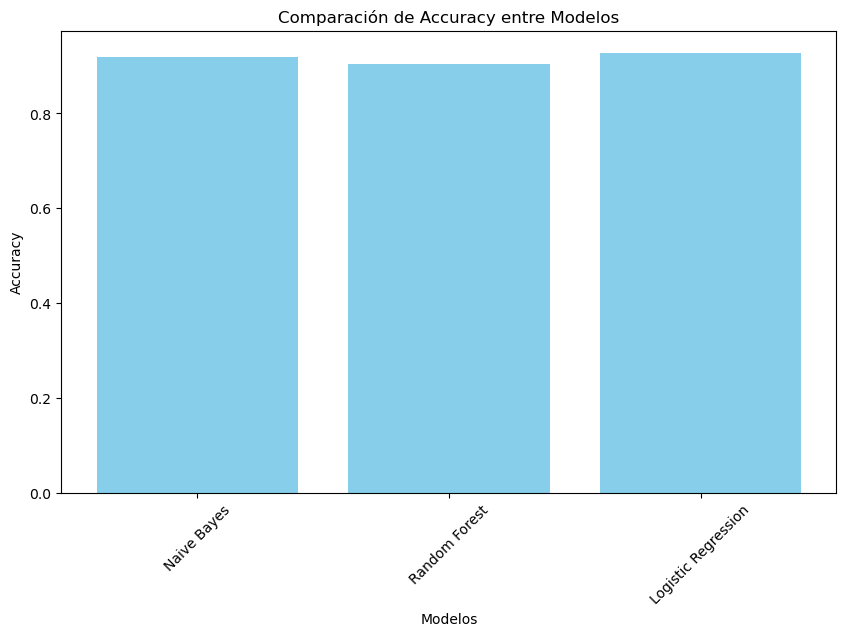

El modelo ganador es: Logistic Regression con Accuracy: 0.9279503105590062
Evaluando el modelo ganador...
Accuracy (Threshold=0.55): 0.9279503105590062
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      3204
           1       0.93      0.92      0.93      3236

    accuracy                           0.93      6440
   macro avg       0.93      0.93      0.93      6440
weighted avg       0.93      0.93      0.93      6440



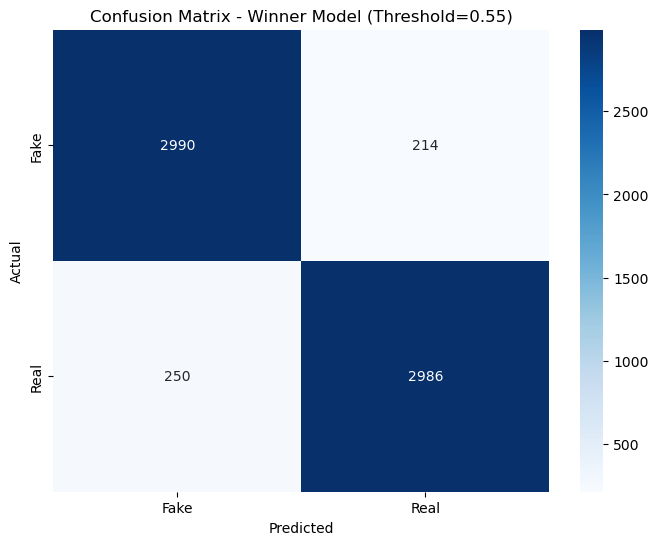

In [73]:
# Obtener y_train e y_test
y_train = train_data['Veracity']
y_test = test_data['Veracity']

# Obtener los modelos
models = get_models()

# Evaluar los modelos
results = evaluate_models(models, X_train, y_train, X_test, y_test, threshold=0.55)

# Comparar los resultados
plot_model_comparisons(results)

# Seleccionar el modelo ganador
best_model_name = max(results, key=lambda name: results[name]['accuracy'])
best_model = results[best_model_name]['model']
print(f"El modelo ganador es: {best_model_name} con Accuracy: {results[best_model_name]['accuracy']}")

# Realizar hyperparameter tuning en el modelo ganador (si aplica)
# Aquí puedes usar tu GridSearchCV y luego evaluar el mejor modelo con:
evaluate_winner(best_model, X_test, y_test, threshold=0.55)

# Hypertunning best model

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mejores hiperparámetros: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Mejor puntuación de validación cruzada: 0.8988938482437415
Accuracy del modelo optimizado: 0.9315217391304348

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      3204
           1       0.92      0.94      0.93      3236

    accuracy                           0.93      6440
   macro avg       0.93      0.93      0.93      6440
weighted avg       0.93      0.93      0.93      6440



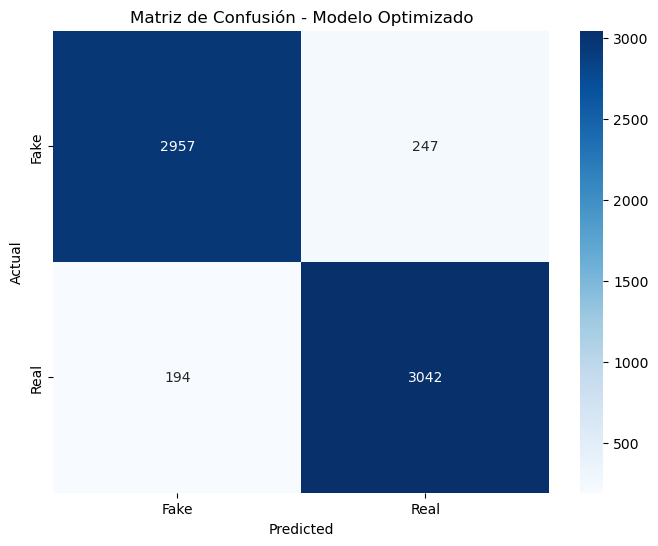

In [76]:
# Espacio de hiperparámetros para Logistic Regression
param_grid = [
    # Solvers compatibles con 'l2'
    {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularización
        'penalty': ['l2'],             # Solo 'l2'
        'solver': ['lbfgs', 'newton-cg', 'sag']  # Solvers compatibles
    },
    # Solvers compatibles con 'l1' y 'l2'
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],      # 'l1' y 'l2'
        'solver': ['liblinear']       # Solver compatible con ambos
    }
]


# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_logreg_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

# Evaluar el modelo optimizado
y_pred_optimized = best_logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_optimized)
report = classification_report(y_test, y_pred_optimized)
conf_matrix = confusion_matrix(y_test, y_pred_optimized)

# Mostrar métricas
print(f"Accuracy del modelo optimizado: {accuracy}")
print("\nClassification Report:\n", report)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Modelo Optimizado')
plt.show()

In [78]:
# Comparar Accuracy entre el modelo original y optimizado
original_accuracy = results['Logistic Regression']['accuracy']
optimized_accuracy = accuracy

print(f"Accuracy del modelo original: {original_accuracy}")
print(f"Accuracy del modelo optimizado: {optimized_accuracy}")

Accuracy del modelo original: 0.9279503105590062
Accuracy del modelo optimizado: 0.9315217391304348


In [80]:
import os
import pickle

# Crear el directorio si no existe
os.makedirs("../model", exist_ok=True)

# Guardar el modelo
with open("../model/model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)  # Usa tu mejor modelo entrenado
    print("Model saved successfully!")

# Guardar el vectorizador
with open("../model/vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)  # Usa tu vectorizador entrenado
    print("Vectorizer saved successfully!")

Model saved successfully!
Vectorizer saved successfully!


In [84]:
# Ver las primeras predicciones del modelo
sample_predictions = best_model.predict(X_test[:10])
print("Sample Predictions:", sample_predictions)

# Confirmar las etiquetas originales
print("True Labels:", y_test[:10].tolist())

Sample Predictions: [1 1 0 1 1 0 1 0 1 1]
True Labels: [1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
